In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 4
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'
pcmciplus_features = ['LW_down', 'sst', 'sea_ice_extent']

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

Date  wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0  1/1/1979  5.531398           0.811961  186.687054    3.127880  1.009872   
1  2/1/1979  5.328020           0.688896  174.794571   18.541594  0.920831   
2  3/1/1979  5.432511           0.916124  190.741933   67.690429  0.983327   
3  4/1/1979  4.792836           1.272056  212.937925  156.223673  0.890723   
4  5/1/1979  4.819028           2.239776  253.690478  230.950833  1.201308   

   snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0  0.892319  273.355237  250.388101        984.633032        15604191  
1  0.781347  273.121885  247.071202        983.980418        16378929  
2  0.855266  273.088099  252.954138        985.140468        16521089  
3  0.705203  273.126062  259.557456        989.314698        15561238  
4  0.688723  273.393551  269.375118        984.483658        14085613

In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[pcmciplus_features]
df.tail(len(df))

LW_down         sst  sea_ice_extent
Date                                              
1979-01-01  186.687054  273.355237      15604191.0
1979-02-01  174.794571  273.121885      16378929.0
1979-03-01  190.741933  273.088099      16521089.0
1979-04-01  212.937925  273.126062      15561238.0
1979-05-01  253.690478  273.393551      14085613.0
...                ...         ...             ...
2021-04-01  225.171796  273.470298      13840000.0
2021-05-01  260.956781  273.888627      12660000.0
2021-06-01  294.931709  275.245088      10710000.0
2021-07-01  313.311345  277.253314       7690000.0
2021-08-01  313.003568  278.556142       5750000.0

[512 rows x 3 columns]

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

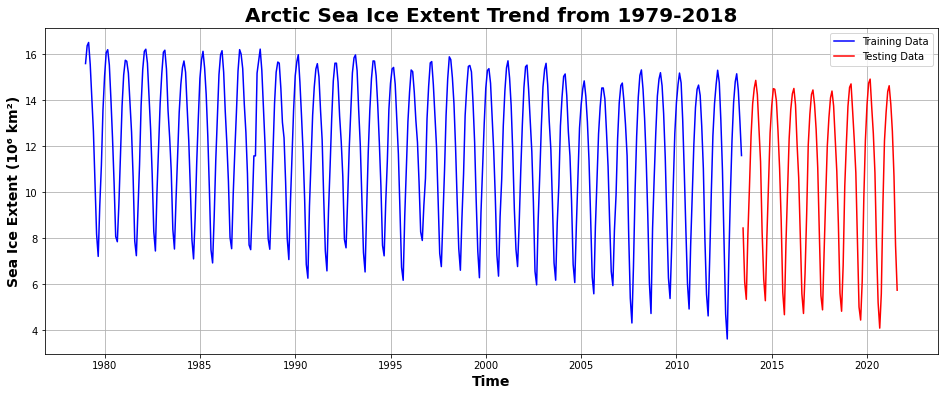

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            13248     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.5853 - mae: 0.6394 - mse: 0.5853

6/6 [==============================] - 19s 536ms/step - loss: 0.5853 - mae: 0.6394 - mse: 0.5853 - val_loss: 0.2115 - val_mae: 0.4010 - val_mse: 0.2115
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.1339 - mae: 0.2990 - mse: 0.1339

6/6 [==============================] - 0s 57ms/step - loss: 0.1275 - mae: 0.2914 - mse: 0.1275 - val_loss: 0.1131 - val_mae: 0.3007 - val_mse: 0.1131
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0853 - mae: 0.2415 - mse: 0.0853

6/6 [==============================] - 0s 48ms/step - loss: 0.0841 - mae: 0.2395 - mse: 0.0841 - val_loss: 0.0831 - val_mae: 0.2344 - val_mse: 0.0831
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0727 - mae: 0.2246 - mse: 0.0727

6/6 [==============================] - 0s 46ms/step - loss: 0.0701 - mae: 0.2209 - mse: 0.0701 - val_loss: 0.0906 - val_mae: 0.2348 - val_mse: 0.0906
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0619 - mae: 0.2052 - mse: 0.0619

6/6 [==============================] - 0s 44ms/step - loss: 0.0605 - mae: 0.2024 - mse: 0.0605 - val_loss: 0.0759 - val_mae: 0.2400 - val_mse: 0.0759
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0640 - mae: 0.2134 - mse: 0.0640

6/6 [==============================] - 0s 45ms/step - loss: 0.0661 - mae: 0.2162 - mse: 0.0661 - val_loss: 0.0838 - val_mae: 0.2311 - val_mse: 0.0838
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0597 - mae: 0.2063 - mse: 0.0597

6/6 [==============================] - 0s 45ms/step - loss: 0.0593 - mae: 0.2068 - mse: 0.0593 - val_loss: 0.0669 - val_mae: 0.2234 - val_mse: 0.0669
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0519 - mae: 0.1916 - mse: 0.0519

6/6 [==============================] - 0s 44ms/step - loss: 0.0518 - mae: 0.1916 - mse: 0.0518 - val_loss: 0.0433 - val_mae: 0.1768 - val_mse: 0.0433
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0709 - mae: 0.2198 - mse: 0.0709

6/6 [==============================] - 0s 44ms/step - loss: 0.0734 - mae: 0.2249 - mse: 0.0734 - val_loss: 0.0777 - val_mae: 0.2481 - val_mse: 0.0777
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0611 - mae: 0.2055 - mse: 0.0611

6/6 [==============================] - 0s 43ms/step - loss: 0.0627 - mae: 0.2083 - mse: 0.0627 - val_loss: 0.0789 - val_mae: 0.2348 - val_mse: 0.0789
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0608 - mae: 0.2114 - mse: 0.0608

6/6 [==============================] - 0s 46ms/step - loss: 0.0618 - mae: 0.2132 - mse: 0.0618 - val_loss: 0.0760 - val_mae: 0.2397 - val_mse: 0.0760
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0627 - mae: 0.2142 - mse: 0.0627

6/6 [==============================] - 0s 44ms/step - loss: 0.0617 - mae: 0.2111 - mse: 0.0617 - val_loss: 0.0811 - val_mae: 0.2338 - val_mse: 0.0811
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0605 - mae: 0.2090 - mse: 0.0605

6/6 [==============================] - 0s 45ms/step - loss: 0.0606 - mae: 0.2095 - mse: 0.0606 - val_loss: 0.0763 - val_mae: 0.2371 - val_mse: 0.0763
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.1997 - mse: 0.0575

6/6 [==============================] - 0s 46ms/step - loss: 0.0586 - mae: 0.2027 - mse: 0.0586 - val_loss: 0.0766 - val_mae: 0.2356 - val_mse: 0.0766
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0565 - mae: 0.2062 - mse: 0.0565

6/6 [==============================] - 0s 45ms/step - loss: 0.0581 - mae: 0.2090 - mse: 0.0581 - val_loss: 0.0760 - val_mae: 0.2352 - val_mse: 0.0760
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0575 - mae: 0.2046 - mse: 0.0575

6/6 [==============================] - 0s 44ms/step - loss: 0.0572 - mae: 0.2048 - mse: 0.0572 - val_loss: 0.0742 - val_mae: 0.2331 - val_mse: 0.0742
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0563 - mae: 0.2039 - mse: 0.0563

6/6 [==============================] - 0s 47ms/step - loss: 0.0547 - mae: 0.2011 - mse: 0.0547 - val_loss: 0.0727 - val_mae: 0.2281 - val_mse: 0.0727
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0518 - mae: 0.1948 - mse: 0.0518

6/6 [==============================] - 0s 47ms/step - loss: 0.0511 - mae: 0.1936 - mse: 0.0511 - val_loss: 0.0630 - val_mae: 0.2175 - val_mse: 0.0630
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0453 - mae: 0.1780 - mse: 0.0453

6/6 [==============================] - 0s 45ms/step - loss: 0.0438 - mae: 0.1748 - mse: 0.0438 - val_loss: 0.0388 - val_mae: 0.1695 - val_mse: 0.0388
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0439 - mae: 0.1692 - mse: 0.0439

6/6 [==============================] - 0s 47ms/step - loss: 0.0453 - mae: 0.1735 - mse: 0.0453 - val_loss: 0.0496 - val_mae: 0.1975 - val_mse: 0.0496
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0385 - mae: 0.1610 - mse: 0.0385

6/6 [==============================] - 0s 45ms/step - loss: 0.0383 - mae: 0.1598 - mse: 0.0383 - val_loss: 0.0479 - val_mae: 0.1716 - val_mse: 0.0479
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0249 - mae: 0.1297 - mse: 0.0249

6/6 [==============================] - 0s 45ms/step - loss: 0.0255 - mae: 0.1298 - mse: 0.0255 - val_loss: 0.0559 - val_mae: 0.1858 - val_mse: 0.0559
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0198 - mae: 0.1113 - mse: 0.0198

6/6 [==============================] - 0s 45ms/step - loss: 0.0188 - mae: 0.1072 - mse: 0.0188 - val_loss: 0.0446 - val_mae: 0.1599 - val_mse: 0.0446
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0154 - mae: 0.0991 - mse: 0.0154

6/6 [==============================] - 0s 46ms/step - loss: 0.0148 - mae: 0.0966 - mse: 0.0148 - val_loss: 0.0212 - val_mae: 0.1044 - val_mse: 0.0212
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0109 - mae: 0.0820 - mse: 0.0109

6/6 [==============================] - 0s 46ms/step - loss: 0.0110 - mae: 0.0822 - mse: 0.0110 - val_loss: 0.0149 - val_mae: 0.0820 - val_mse: 0.0149
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0100 - mae: 0.0751 - mse: 0.0100

6/6 [==============================] - 0s 44ms/step - loss: 0.0097 - mae: 0.0746 - mse: 0.0097 - val_loss: 0.0070 - val_mae: 0.0525 - val_mse: 0.0070
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0090 - mae: 0.0749 - mse: 0.0090

6/6 [==============================] - 0s 45ms/step - loss: 0.0091 - mae: 0.0757 - mse: 0.0091 - val_loss: 0.0084 - val_mae: 0.0606 - val_mse: 0.0084
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0091 - mae: 0.0749 - mse: 0.0091

6/6 [==============================] - 0s 46ms/step - loss: 0.0089 - mae: 0.0742 - mse: 0.0089 - val_loss: 0.0098 - val_mae: 0.0684 - val_mse: 0.0098
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0073 - mae: 0.0678 - mse: 0.0073

6/6 [==============================] - 0s 44ms/step - loss: 0.0077 - mae: 0.0689 - mse: 0.0077 - val_loss: 0.0126 - val_mae: 0.0892 - val_mse: 0.0126
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0065 - mae: 0.0613 - mse: 0.0065

6/6 [==============================] - 0s 46ms/step - loss: 0.0065 - mae: 0.0618 - mse: 0.0065 - val_loss: 0.0093 - val_mae: 0.0689 - val_mse: 0.0093
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0659 - mse: 0.0072

6/6 [==============================] - 0s 44ms/step - loss: 0.0071 - mae: 0.0660 - mse: 0.0071 - val_loss: 0.0102 - val_mae: 0.0726 - val_mse: 0.0102
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0067 - mae: 0.0640 - mse: 0.0067

6/6 [==============================] - 0s 45ms/step - loss: 0.0066 - mae: 0.0637 - mse: 0.0066 - val_loss: 0.0149 - val_mae: 0.0911 - val_mse: 0.0149
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0072 - mae: 0.0671 - mse: 0.0072

6/6 [==============================] - 0s 47ms/step - loss: 0.0069 - mae: 0.0658 - mse: 0.0069 - val_loss: 0.0154 - val_mae: 0.0898 - val_mse: 0.0154
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0623 - mse: 0.0064

6/6 [==============================] - 0s 46ms/step - loss: 0.0064 - mae: 0.0622 - mse: 0.0064 - val_loss: 0.0071 - val_mae: 0.0581 - val_mse: 0.0071
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0052 - mae: 0.0558 - mse: 0.0052

6/6 [==============================] - 0s 45ms/step - loss: 0.0054 - mae: 0.0568 - mse: 0.0054 - val_loss: 0.0055 - val_mae: 0.0491 - val_mse: 0.0055
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0569 - mse: 0.0053

6/6 [==============================] - 0s 44ms/step - loss: 0.0052 - mae: 0.0570 - mse: 0.0052 - val_loss: 0.0106 - val_mae: 0.0767 - val_mse: 0.0106
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0590 - mse: 0.0056

6/6 [==============================] - 0s 44ms/step - loss: 0.0054 - mae: 0.0580 - mse: 0.0054 - val_loss: 0.0069 - val_mae: 0.0622 - val_mse: 0.0069
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0536 - mse: 0.0047

6/6 [==============================] - 0s 46ms/step - loss: 0.0047 - mae: 0.0534 - mse: 0.0047 - val_loss: 0.0054 - val_mae: 0.0546 - val_mse: 0.0054
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0567 - mse: 0.0051

6/6 [==============================] - 0s 44ms/step - loss: 0.0053 - mae: 0.0579 - mse: 0.0053 - val_loss: 0.0081 - val_mae: 0.0702 - val_mse: 0.0081
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0054 - mae: 0.0589 - mse: 0.0054

6/6 [==============================] - 0s 45ms/step - loss: 0.0052 - mae: 0.0577 - mse: 0.0052 - val_loss: 0.0045 - val_mae: 0.0494 - val_mse: 0.0045
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0519 - mse: 0.0044

6/6 [==============================] - 0s 46ms/step - loss: 0.0044 - mae: 0.0517 - mse: 0.0044 - val_loss: 0.0040 - val_mae: 0.0437 - val_mse: 0.0040
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0504 - mse: 0.0040

6/6 [==============================] - 0s 45ms/step - loss: 0.0042 - mae: 0.0510 - mse: 0.0042 - val_loss: 0.0040 - val_mae: 0.0519 - val_mse: 0.0040
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0485 - mse: 0.0040

6/6 [==============================] - 0s 47ms/step - loss: 0.0040 - mae: 0.0494 - mse: 0.0040 - val_loss: 0.0043 - val_mae: 0.0436 - val_mse: 0.0043
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0503 - mse: 0.0040

6/6 [==============================] - 0s 47ms/step - loss: 0.0039 - mae: 0.0497 - mse: 0.0039 - val_loss: 0.0030 - val_mae: 0.0384 - val_mse: 0.0030
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0533 - mse: 0.0045

6/6 [==============================] - 0s 46ms/step - loss: 0.0046 - mae: 0.0533 - mse: 0.0046 - val_loss: 0.0050 - val_mae: 0.0501 - val_mse: 0.0050
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0498 - mse: 0.0039

6/6 [==============================] - 0s 45ms/step - loss: 0.0040 - mae: 0.0502 - mse: 0.0040 - val_loss: 0.0047 - val_mae: 0.0448 - val_mse: 0.0047
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0506 - mse: 0.0040

6/6 [==============================] - 0s 46ms/step - loss: 0.0039 - mae: 0.0503 - mse: 0.0039 - val_loss: 0.0036 - val_mae: 0.0447 - val_mse: 0.0036
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0478 - mse: 0.0037

6/6 [==============================] - 0s 45ms/step - loss: 0.0037 - mae: 0.0480 - mse: 0.0037 - val_loss: 0.0040 - val_mae: 0.0462 - val_mse: 0.0040
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0518 - mse: 0.0042

6/6 [==============================] - 0s 47ms/step - loss: 0.0042 - mae: 0.0515 - mse: 0.0042 - val_loss: 0.0032 - val_mae: 0.0405 - val_mse: 0.0032
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0500 - mse: 0.0040

6/6 [==============================] - 0s 51ms/step - loss: 0.0038 - mae: 0.0491 - mse: 0.0038 - val_loss: 0.0026 - val_mae: 0.0359 - val_mse: 0.0026
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0473 - mse: 0.0036

6/6 [==============================] - 0s 44ms/step - loss: 0.0034 - mae: 0.0460 - mse: 0.0034 - val_loss: 0.0025 - val_mae: 0.0360 - val_mse: 0.0025
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0488 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0035 - mae: 0.0483 - mse: 0.0035 - val_loss: 0.0031 - val_mae: 0.0392 - val_mse: 0.0031
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0463 - mse: 0.0034

6/6 [==============================] - 0s 47ms/step - loss: 0.0036 - mae: 0.0474 - mse: 0.0036 - val_loss: 0.0049 - val_mae: 0.0557 - val_mse: 0.0049
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0492 - mse: 0.0039

6/6 [==============================] - 0s 47ms/step - loss: 0.0038 - mae: 0.0486 - mse: 0.0038 - val_loss: 0.0041 - val_mae: 0.0495 - val_mse: 0.0041
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0518 - mse: 0.0041

6/6 [==============================] - 0s 45ms/step - loss: 0.0039 - mae: 0.0498 - mse: 0.0039 - val_loss: 0.0034 - val_mae: 0.0461 - val_mse: 0.0034
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0448 - mse: 0.0031

6/6 [==============================] - 0s 47ms/step - loss: 0.0032 - mae: 0.0454 - mse: 0.0032 - val_loss: 0.0031 - val_mae: 0.0406 - val_mse: 0.0031
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0459 - mse: 0.0034

6/6 [==============================] - 0s 46ms/step - loss: 0.0036 - mae: 0.0475 - mse: 0.0036 - val_loss: 0.0022 - val_mae: 0.0335 - val_mse: 0.0022
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0042 - mae: 0.0514 - mse: 0.0042

6/6 [==============================] - 0s 46ms/step - loss: 0.0041 - mae: 0.0515 - mse: 0.0041 - val_loss: 0.0026 - val_mae: 0.0342 - val_mse: 0.0026
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0469 - mse: 0.0035

6/6 [==============================] - 0s 49ms/step - loss: 0.0035 - mae: 0.0473 - mse: 0.0035 - val_loss: 0.0022 - val_mae: 0.0351 - val_mse: 0.0022
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0485 - mse: 0.0036

6/6 [==============================] - 0s 45ms/step - loss: 0.0036 - mae: 0.0480 - mse: 0.0036 - val_loss: 0.0024 - val_mae: 0.0341 - val_mse: 0.0024
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0438 - mse: 0.0032

6/6 [==============================] - 0s 46ms/step - loss: 0.0032 - mae: 0.0447 - mse: 0.0032 - val_loss: 0.0040 - val_mae: 0.0494 - val_mse: 0.0040
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0494 - mse: 0.0039

6/6 [==============================] - 0s 45ms/step - loss: 0.0038 - mae: 0.0489 - mse: 0.0038 - val_loss: 0.0037 - val_mae: 0.0496 - val_mse: 0.0037
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0473 - mse: 0.0036

6/6 [==============================] - 0s 45ms/step - loss: 0.0037 - mae: 0.0477 - mse: 0.0037 - val_loss: 0.0030 - val_mae: 0.0395 - val_mse: 0.0030
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0461 - mse: 0.0032

6/6 [==============================] - 0s 47ms/step - loss: 0.0031 - mae: 0.0451 - mse: 0.0031 - val_loss: 0.0017 - val_mae: 0.0309 - val_mse: 0.0017
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0463 - mse: 0.0034

6/6 [==============================] - 0s 44ms/step - loss: 0.0034 - mae: 0.0460 - mse: 0.0034 - val_loss: 0.0038 - val_mae: 0.0504 - val_mse: 0.0038
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0474 - mse: 0.0034

6/6 [==============================] - 0s 46ms/step - loss: 0.0035 - mae: 0.0478 - mse: 0.0035 - val_loss: 0.0019 - val_mae: 0.0326 - val_mse: 0.0019
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0424 - mse: 0.0029

6/6 [==============================] - 0s 47ms/step - loss: 0.0032 - mae: 0.0444 - mse: 0.0032 - val_loss: 0.0023 - val_mae: 0.0371 - val_mse: 0.0023
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0470 - mse: 0.0034

6/6 [==============================] - 0s 47ms/step - loss: 0.0034 - mae: 0.0471 - mse: 0.0034 - val_loss: 0.0016 - val_mae: 0.0313 - val_mse: 0.0016
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0446 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0030 - mae: 0.0445 - mse: 0.0030 - val_loss: 0.0027 - val_mae: 0.0422 - val_mse: 0.0027
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0443 - mse: 0.0031

6/6 [==============================] - 0s 45ms/step - loss: 0.0032 - mae: 0.0450 - mse: 0.0032 - val_loss: 0.0021 - val_mae: 0.0346 - val_mse: 0.0021
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0405 - mse: 0.0026

6/6 [==============================] - 0s 47ms/step - loss: 0.0026 - mae: 0.0404 - mse: 0.0026 - val_loss: 0.0019 - val_mae: 0.0329 - val_mse: 0.0019
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0396 - mse: 0.0026

6/6 [==============================] - 0s 45ms/step - loss: 0.0026 - mae: 0.0388 - mse: 0.0026 - val_loss: 0.0020 - val_mae: 0.0329 - val_mse: 0.0020
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0416 - mse: 0.0028

6/6 [==============================] - 0s 46ms/step - loss: 0.0028 - mae: 0.0418 - mse: 0.0028 - val_loss: 0.0023 - val_mae: 0.0358 - val_mse: 0.0023
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0453 - mse: 0.0033

6/6 [==============================] - 0s 47ms/step - loss: 0.0032 - mae: 0.0444 - mse: 0.0032 - val_loss: 0.0034 - val_mae: 0.0478 - val_mse: 0.0034
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0426 - mse: 0.0029

6/6 [==============================] - 0s 46ms/step - loss: 0.0029 - mae: 0.0429 - mse: 0.0029 - val_loss: 0.0023 - val_mae: 0.0359 - val_mse: 0.0023
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0408 - mse: 0.0027

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0419 - mse: 0.0028 - val_loss: 0.0026 - val_mae: 0.0378 - val_mse: 0.0026
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0448 - mse: 0.0032

6/6 [==============================] - 0s 47ms/step - loss: 0.0031 - mae: 0.0443 - mse: 0.0031 - val_loss: 0.0024 - val_mae: 0.0390 - val_mse: 0.0024
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0427 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0031 - mae: 0.0435 - mse: 0.0031 - val_loss: 0.0028 - val_mae: 0.0444 - val_mse: 0.0028
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0470 - mse: 0.0034

6/6 [==============================] - 0s 48ms/step - loss: 0.0034 - mae: 0.0467 - mse: 0.0034 - val_loss: 0.0020 - val_mae: 0.0357 - val_mse: 0.0020
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0408 - mse: 0.0028

6/6 [==============================] - 0s 46ms/step - loss: 0.0027 - mae: 0.0409 - mse: 0.0027 - val_loss: 0.0017 - val_mae: 0.0316 - val_mse: 0.0017
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0395 - mse: 0.0025

6/6 [==============================] - 0s 45ms/step - loss: 0.0025 - mae: 0.0391 - mse: 0.0025 - val_loss: 0.0026 - val_mae: 0.0423 - val_mse: 0.0026
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0022 - mae: 0.0371 - mse: 0.0022

6/6 [==============================] - 0s 46ms/step - loss: 0.0023 - mae: 0.0376 - mse: 0.0023 - val_loss: 0.0015 - val_mae: 0.0306 - val_mse: 0.0015
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0404 - mse: 0.0025

6/6 [==============================] - 0s 48ms/step - loss: 0.0025 - mae: 0.0405 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0451 - val_mse: 0.0030
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0391 - mse: 0.0025

6/6 [==============================] - 0s 47ms/step - loss: 0.0024 - mae: 0.0384 - mse: 0.0024 - val_loss: 0.0035 - val_mae: 0.0521 - val_mse: 0.0035
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0023 - mae: 0.0377 - mse: 0.0023

6/6 [==============================] - 0s 49ms/step - loss: 0.0024 - mae: 0.0381 - mse: 0.0024 - val_loss: 0.0024 - val_mae: 0.0412 - val_mse: 0.0024
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0414 - mse: 0.0028

6/6 [==============================] - 0s 48ms/step - loss: 0.0028 - mae: 0.0418 - mse: 0.0028 - val_loss: 0.0027 - val_mae: 0.0425 - val_mse: 0.0027
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0447 - mse: 0.0032

6/6 [==============================] - 0s 48ms/step - loss: 0.0032 - mae: 0.0452 - mse: 0.0032 - val_loss: 0.0021 - val_mae: 0.0332 - val_mse: 0.0021
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0412 - mse: 0.0026

6/6 [==============================] - 0s 48ms/step - loss: 0.0026 - mae: 0.0410 - mse: 0.0026 - val_loss: 0.0023 - val_mae: 0.0379 - val_mse: 0.0023
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0421 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0418 - mse: 0.0028 - val_loss: 0.0018 - val_mae: 0.0334 - val_mse: 0.0018
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0452 - mse: 0.0031

6/6 [==============================] - 0s 47ms/step - loss: 0.0031 - mae: 0.0454 - mse: 0.0031 - val_loss: 0.0023 - val_mae: 0.0391 - val_mse: 0.0023
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0418 - mse: 0.0028

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0416 - mse: 0.0028 - val_loss: 0.0014 - val_mae: 0.0301 - val_mse: 0.0014
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0025 - mae: 0.0394 - mse: 0.0025

6/6 [==============================] - 0s 46ms/step - loss: 0.0026 - mae: 0.0403 - mse: 0.0026 - val_loss: 0.0027 - val_mae: 0.0428 - val_mse: 0.0027
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0427 - mse: 0.0028

6/6 [==============================] - 0s 45ms/step - loss: 0.0028 - mae: 0.0433 - mse: 0.0028 - val_loss: 0.0035 - val_mae: 0.0505 - val_mse: 0.0035
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0404 - mse: 0.0026

6/6 [==============================] - 0s 47ms/step - loss: 0.0026 - mae: 0.0399 - mse: 0.0026 - val_loss: 0.0025 - val_mae: 0.0390 - val_mse: 0.0025
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0021 - mae: 0.0351 - mse: 0.0021

6/6 [==============================] - 0s 45ms/step - loss: 0.0021 - mae: 0.0353 - mse: 0.0021 - val_loss: 0.0042 - val_mae: 0.0601 - val_mse: 0.0042
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0422 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0423 - mse: 0.0028 - val_loss: 0.0015 - val_mae: 0.0300 - val_mse: 0.0015
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0411 - mse: 0.0029

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0408 - mse: 0.0028 - val_loss: 0.0033 - val_mae: 0.0478 - val_mse: 0.0033
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0425 - mse: 0.0027

6/6 [==============================] - 0s 47ms/step - loss: 0.0027 - mae: 0.0425 - mse: 0.0027 - val_loss: 0.0022 - val_mae: 0.0387 - val_mse: 0.0022
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0404 - mse: 0.0027

6/6 [==============================] - 0s 48ms/step - loss: 0.0027 - mae: 0.0404 - mse: 0.0027 - val_loss: 0.0018 - val_mae: 0.0348 - val_mse: 0.0018
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0394 - mse: 0.0024

6/6 [==============================] - 0s 47ms/step - loss: 0.0024 - mae: 0.0394 - mse: 0.0024 - val_loss: 0.0027 - val_mae: 0.0434 - val_mse: 0.0027


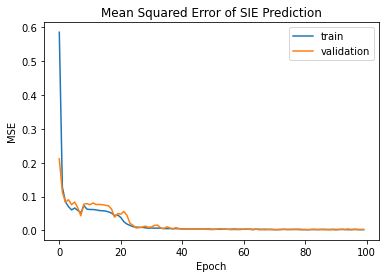

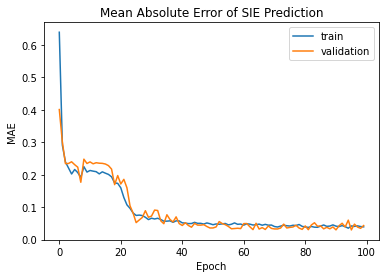

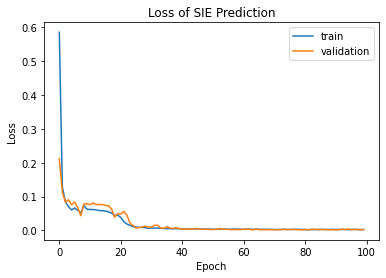

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 19ms/step


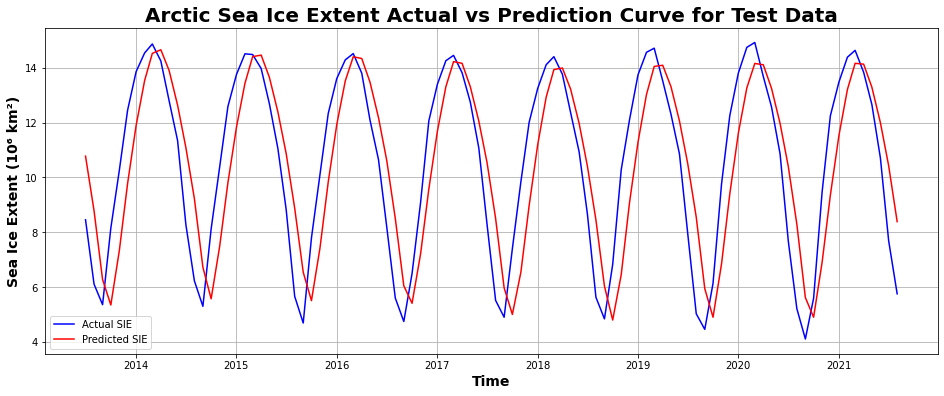

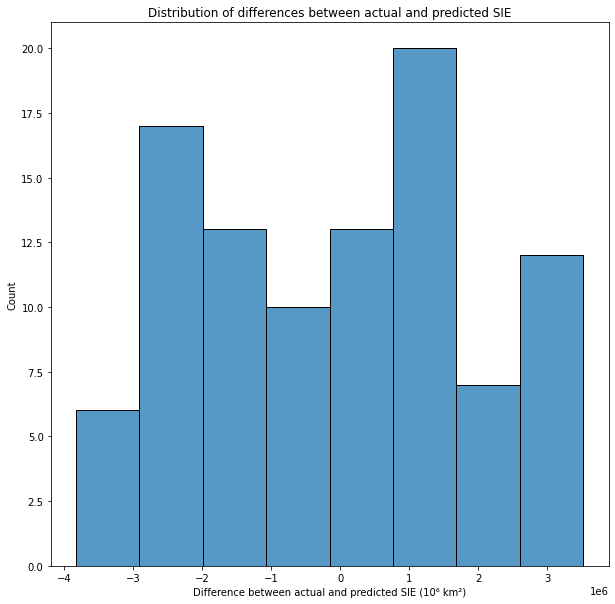

MSE :  3857662040916.018 (10⁶ km²)
MSPE : 6.316 %
RMSE :  1964093.1853952394 (10⁶ km²)
RMSPE : 25.133 %
MAE :  1716816.7091836734 (10⁶ km²)
MAPE :  19.736 %
R2 :  58.425


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass